In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot,lag_plot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
import math 
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from  datetime import datetime, timedelta
from sklearn.linear_model import Ridge

In [6]:
data = pd.read_excel('Usecase2_Dataset.xlsx', skiprows=2) 
data= data.reset_index(drop=True)
# As Data is for Jan 2016 till 2019. Frequency is weekly
date_col = pd.date_range(start='1/1/2016', periods=206, freq='W')
data.columns = ['Part_No'] + date_col.to_list()
data.head(3)

,Part_No,2016-01-03 00:00:00,2016-01-10 00:00:00,2016-01-17 00:00:00,2016-01-24 00:00:00,2016-01-31 00:00:00,2016-02-07 00:00:00,2016-02-14 00:00:00,2016-02-21 00:00:00,2016-02-28 00:00:00,2016-03-06 00:00:00,2016-03-13 00:00:00,2016-03-20 00:00:00,2016-03-27 00:00:00,2016-04-03 00:00:00,2016-04-10 00:00:00,2016-04-17 00:00:00,2016-04-24 00:00:00,2016-05-01 00:00:00,2016-05-08 00:00:00,2016-05-15 00:00:00,2016-05-22 00:00:00,2016-05-29 00:00:00,2016-06-05 00:00:00,2016-06-12 00:00:00,2016-06-19 00:00:00,2016-06-26 00:00:00,2016-07-03 00:00:00,2016-07-10 00:00:00,2016-07-17 00:00:00,2016-07-24 00:00:00,2016-07-31 00:00:00,2016-08-07 00:00:00,2016-08-14 00:00:00,2016-08-21 00:00:00,2016-08-28 00:00:00,2016-09-04 00:00:00,2016-09-11 00:00:00,2016-09-18 00:00:00,2016-09-25 00:00:00,...,2019-03-10 00:00:00,2019-03-17 00:00:00,2019-03-24 00:00:00,2019-03-31 00:00:00,2019-04-07 00:00:00,2019-04-14 00:00:00,2019-04-21 00:00:00,2019-04-28 00:00:00,2019-05-05 00:00:00,2019-05-12 00:00:00,2019-05-19 00:00:00,2019-05-26 00:00:00,2019-06-02 00:00:00,2019-06-09 00:00:00,2019-06-16 00:00:00,2019-06-23 00:00:00,2019-06-30 00:00:00,2019-07-07 00:00:00,2019-07-14 00:00:00,2019-07-21 00:00:00,2019-07-28 00:00:00,2019-08-04 00:00:00,2019-08-11 00:00:00,2019-08-18 00:00:00,2019-08-25 00:00:00,2019-09-01 00:00:00,2019-09-08 00:00:00,2019-09-15 00:00:00,2019-09-22 00:00:00,2019-09-29 00:00:00,2019-10-06 00:00:00,2019-10-13 00:00:00,2019-10-20 00:00:00,2019-10-27 00:00:00,2019-11-03 00:00:00,2019-11-10 00:00:00,2019-11-17 00:00:00,2019-11-24 00:00:00,2019-12-01 00:00:00,2019-12-08 00:00:00
0,29032636,432,9316,8964,9000,6264,10476,9180,8856,6228,9468,9468,9288,5436,9756,5760,8424,9396,8604,11088,7920,9901,8748,1548,576,9756,10260,9396,8604,7524,9252,7992,6768,8100,1944,7920,9504,8928,7633,10476,...,1116,1116,576,936,1080,1152,792,828,685,937,756,720,828,864,1260,1008,108,900,864,1045,1008,1188,1620,720,1333,1548,685,1152,972,1116,1512,1512,1260,1369,432,180,1404,1332,972,1512
1,29032635,432,9316,8964,9000,6192,10476,9180,8892,6228,9468,9468,9288,5436,9756,5760,8424,9396,8604,11088,7920,9901,8748,1548,576,9756,10260,9396,8604,7524,9216,7992,6732,8100,1944,7920,9504,8928,7634,10476,...,1116,1116,576,936,1080,1152,792,833,686,936,756,720,828,864,1260,1008,108,900,864,1045,1008,1188,1620,720,1333,1548,685,1152,972,1116,1512,1512,1260,1368,432,180,1404,1332,972,1512
2,29033235,0,0,0,0,0,0,0,0,0,,0,0,0,,0,0,0,0,0,0,0,0,,0,0,0,,0,0,0,0,0,0,0,0,,0,0,0,...,3690,3780,1935,3653,3016,3735,2970,3510,3468,3870,3285,3240,3375,3060,3690,3330,405,3420,3195,3060,2835,2970,2565,765,1260,1935,1891,2520,2790,2565,2070,2250,1620,1665,855,495,3195,3735,2565,4140


As noted above output of the data, it seems 'Part No' is repeaing.
Reasons can be
  * Either Data collection issue
  * Or, Sales are recorde for same part from different streams

Assumtion-:
As we want to predict the overall demand for the 'Part No' so that we should manage ourr inventory just right amount of products.

So, I will aggregate the demand per 'Part No'


In [7]:
data.Part_No.value_counts()

29032728      5
29032729      5
29033064      4
29032407      4
29033065      4
             ..
29032997      1
32054388EG    1
29033320      1
29033110      1
32054033      1
Name: Part_No, Length: 190, dtype: int64

**Removing Duplicate Records & Then aggregating the demand group by 'Part_No'**


In [8]:
display(data.shape)
data.drop_duplicates(inplace=True)
display(data.shape)
data = data.groupby(['Part_No']).sum().reset_index()
data.shape

(337, 207)

(337, 207)

(190, 178)

**As 2019 is used as test data.**

**So 2019 data will not be used for any EDA because that is the unseen data and it shouldnt be included in any analysis**

**Melting DataFrame**


In [9]:
data = pd.melt(data,
                  id_vars = ['Part_No'],
                  value_vars = [col for col in data.columns if col not in ['Part_No']],
                  var_name = "d",
                  value_name = "sales")
data.head(5)

,Part_No,d,sales
0,18345617,2016-01-03,0
1,18345618,2016-01-03,0
2,19316005,2016-01-03,0
3,19316006,2016-01-03,0
4,29032395,2016-01-03,24


**Creating Train/Test data**

Last 12 weeks data will considered as test data

 
**There are some Part_No which is 0 demand throughtout, so better to handle them seperately than putting it into the model**

In [10]:
data = data[ ~ data.Part_No.isin([29033332,29033333,29033340,29033341,29033354,29033355,29033256,29033257])]
train = data.loc[data.d < '2019-09-15']
test = data.loc[data.d >= '2019-09-15']

In [11]:
train.dtypes

Part_No            object
d          datetime64[ns]
sales               int64
dtype: object

**Now time for some basic analysis of data**


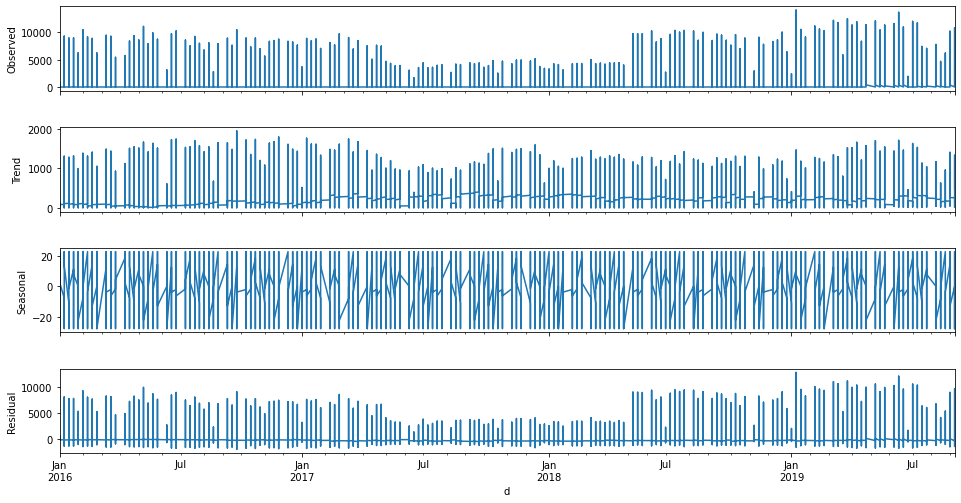

In [12]:
# train.set_index(train.d,inplace=True)
train.index = pd.DatetimeIndex(train.d).to_period('W-Sun')
sales_weekly = train['sales'].resample('W').mean()
decomposition = sm.tsa.seasonal_decompose(train['sales'], model='additive',freq=24)
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

# From the above Plot it is depicted 


1.   **There is an almost linear Trend till july 2017, then the trend is upwards.**
2.   **From Seasonal plot it can be depicted, there is a clear seasonality in the data.**
3.   **From residual plot the , variance does not follow any trend,there is no evidence found for non-stationarity of time series, So need more sophisticated methods for check for stationarity**






In [13]:
result = adfuller(train['sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
result

ADF Statistic: -25.476834
p-value: 0.000000


(-25.476834292636152,
 0.0,
 50,
 29979,
 {'1%': -3.430568148037415,
  '10%': -2.56682131904663,
  '5%': -2.861636415533432},
 483123.739293657)

**p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.**

**So out time series is stationary**

**Now that we know its stationary, we need to see if its correlated (there’s an assumption of dependance / correlation for autoregression)**

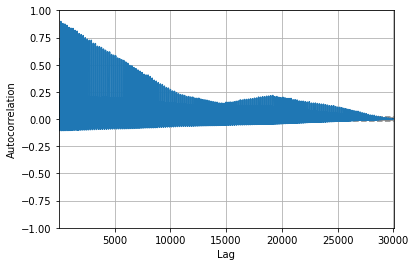

In [14]:
# lag_plot(train.sales,lag=1)
autocorrelation_plot(train.sales)
pyplot.show()

**As we move ahead with lag , the correlation is decreasing**

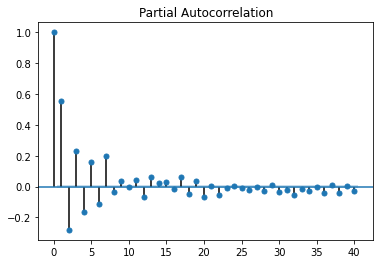

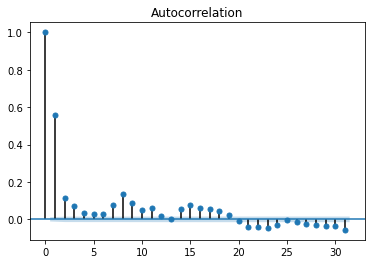

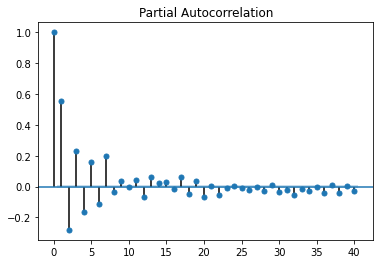

In [16]:
plot_acf(train.sales,lags=31)
plot_pacf(train.sales, lags=40)

**As there is not much of the correlation with the lags , AR model will not be very effective, so will try with other Time series models such as ARIMA**

**Check for any Missing Data**



In [17]:
data.isna().sum()

Part_No    0
d          0
sales      0
dtype: int64

**As each Part_No is a seperate Time series, so ARIMA model is trained for each of the product**

In [19]:
test['Pred_ARIMA'] = 0
for part_no in train.Part_No.drop_duplicates():
  model = ARIMA(train[train.Part_No == part_no].sales, order=(5,1,0))
  # model = SARIMAX(train[train.Part_No == part_no].sales, trend='n', order=(5,1,0), seasonal_order=(3,1,1,24))
  model_fit = model.fit(disp=0)
  pred,se,ce =model_fit.forecast(12, alpha=0.05)
  # pred = model_fit.forecast(12, alpha=0.05)
  test.loc[test.Part_No == part_no ,['Pred_ARIMA']] = pred

test.Pred_ARIMA = np.where(test.Pred_ARIMA < 0,0 ,test.Pred_ARIMA)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

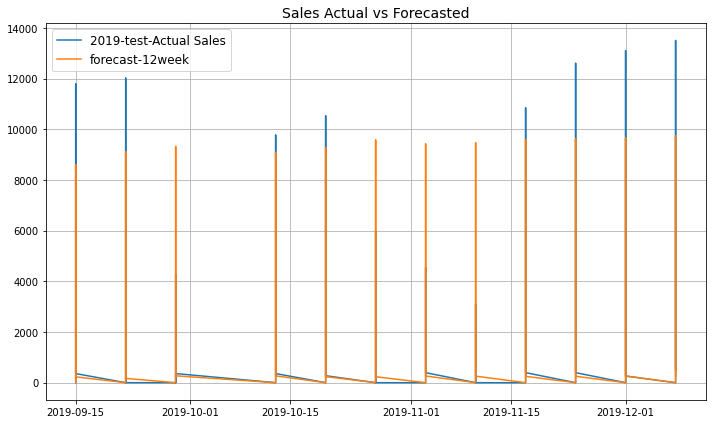

In [20]:

train_2019 = train[train.d>= '2019-01-01']
test.set_index(test.d,inplace=True)
pyplot.figure(figsize=(10,6))
# pyplot.plot(train_2019.sales.resample('W').mean(), label='2019-Sales')
pyplot.plot(test.sales, label='2019-test-Actual Sales')
pyplot.plot(test.Pred_ARIMA, label='forecast-12week')
pyplot.grid(True)
pyplot.title("Sales Actual vs Forecasted",fontsize=14)
pyplot.tight_layout()
pyplot.legend(fontsize=12)
pyplot.show()

In [24]:
rmse = math.sqrt(mean_squared_error(test.sales, test.Pred_ARIMA))
mae = mean_absolute_error(test.sales, test.Pred_ARIMA)
r2score = r2_score(test.sales, test.Pred_ARIMA)

print("RMSE: "+str(rmse))
print("MAE: "+str(mae)) 
print("R2 score: "+str(r2score)) 

RMSE: 580.6304115408458
MAE: 208.8271460424267
R2 score: 0.7813160672268522


**From the metric calculated above using predictions made from very simple model. Since R2 score is 0.78 that means 78% of variation is explained by the model**

**Now lets try with another approach, using much machine learning models i.e Random Forest Model and compare how it performs against Time Series Model.** 

***However Tree Based Models have difficuilty in predit increasing/decreasing unseen Trend due to the nature of Algorithm***

**Also below Random Forest model implementation didnt turned out to be good. So I would stick with above TimeSeries Model as it was able to capture Trend & Seasonality**


**Note - This is just for comparison between the models**


Next Steps would be -:

**Features Creation**
*   Date/Year/Month/Weekday/is_weekend based features
*   Features based on  lag variables on sales
*   Compute rolling  mean & std on those lag variables

**Model Building**

*   Random Forest

**Model Metrics**


*   RMSE
*   MAE
*   R2 Score

In [26]:
def create_fea(dt):
    lags = [1,6,12]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        print(str(lag)+" "+lag_col)
        dt[lag_col] = dt[["Part_No","sales"]].groupby("Part_No")["sales"].transform(lambda x: x.shift(lag))

    wins = [4,8]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["Part_No", lag_col]].groupby("Part_No")[lag_col].transform(lambda x : x.rolling(win).mean())
            dt[f"rstd_{lag}_{win}"] = dt[["Part_No", lag_col]].groupby("Part_No")[lag_col].transform(lambda x : x.rolling(win).std())  
            dt[f"rmin_{lag}_{win}"] = dt[["Part_No", lag_col]].groupby("Part_No")[lag_col].transform(lambda x : x.rolling(win).min())  
            dt[f"rmax_{lag}_{win}"] = dt[["Part_No", lag_col]].groupby("Part_No")[lag_col].transform(lambda x : x.rolling(win).max())
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
        "ime": "is_month_end",
        "ims": "is_month_start",
    }
        
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["d"].dt, date_feat_func).astype("int16")

In [ ]:
create_fea(train)

In [28]:
train_cols = [col  for col in train.columns if col not in ['Part_No', 'd', 'sales']]

**Now that we have created features, Below we will look at some plots between Actuall and Lag features just to check for any correlation between them**

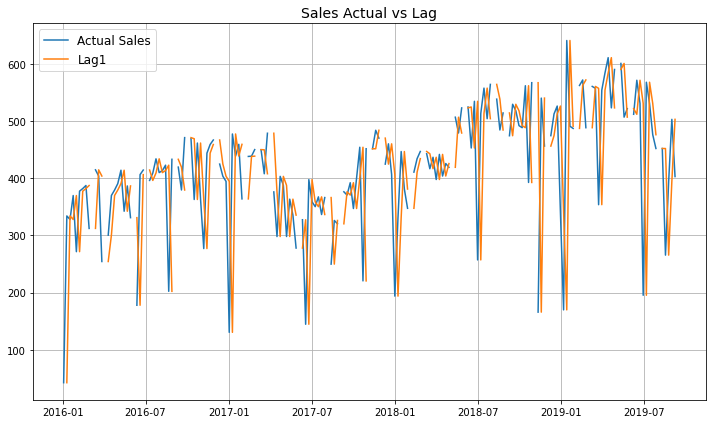

In [35]:
pyplot.figure(figsize=(10,6))

train = train.reset_index(drop=True)
train.set_index(train.d,inplace=True)

pyplot.plot(train.sales.resample('W').mean().T,  label='Actual Sales')
# pyplot.plot(train[train.Part_No == 19316005].lag_12.resample('W').mean().T,  label='Lag12')
pyplot.plot(train.lag_1.resample('W').mean().T,  label='Lag1')


pyplot.grid(True)
pyplot.title("Sales Actual vs Lag",fontsize=14)
pyplot.tight_layout()
pyplot.legend(fontsize=12)
pyplot.show()


**We need to calculate Lags for test data, so we will total of 24 weeks data , whereas first 12 weeks data will be used to calculate lag features & prediction will be made on last 12 weeks**

**Sales will be made 0 for the last 12 weeks so that there is no leakage in the model**

In [ ]:
test_lgb = data.loc[data.d > '2018-09-01']
test_lgb.loc[data.d >= '2019-09-15','sales'] = 0
test_lgb[(test_lgb.Part_No == 19316005) & (test_lgb.d >= '2019-09-15')]

**Out of Train data , keeping some data as valid data, which will not be part of training**

In [31]:
np.random.seed(777)


rf = RandomForestRegressor(1000,oob_score=True)
rf.fit(train.fillna(0)[train_cols],train['sales'])

# lr = Ridge(alpha=1.0, fit_intercept=True,normalize=True)
# lr.fit(train.fillna(0)[train_cols],train['sales'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
te_sub = pd.DataFrame()
te = test_lgb
fday = datetime(2019,9, 15)
max_lags=20

for tdelta in test.d.drop_duplicates():
  day = tdelta
  print(day)
  tst = te[(te.d >= day - timedelta(days=max_lags)) & (te.d <= day)].copy()
  create_fea(tst)
  tst = tst.loc[tst.d == day , train_cols]
  te.loc[te.d == day, "sales"] = rf.predict(tst.fillna(0)) 
  te_sub = te.loc[te.d >= fday, ["Part_No",'d' ,"sales"]].copy()
 


In [33]:
te_sub.rename({'sales':'pred'},inplace=True,axis=1)


rmse_tree = math.sqrt(mean_squared_error(test.sales, te_sub.pred))
mae_tree = mean_absolute_error(test.sales, te_sub.pred)
r2score_tree = r2_score(test.sales, te_sub.pred)

print("RMSE: "+str(rmse_tree))
print("MAE: "+str(mae_tree)) 
print("R2 score: "+str(r2score_tree)) 


RMSE: 903.2257114002346
MAE: 454.7205174098356
R2 score: 0.47081210520791117


**Approach 1- Using Timeseries ARIMA model, test metric were**

*   RMSE: 580.6304115408458
*   MAE: 208.8271460424267
*   R2 score: 0.7813160672268522

**Approach 2- Using Random Forest model, test metrics were**

*   RMSE: 903.2257114002346
*   MAE: 454.7205174098356
*   R2 score: 0.47081210520791117





Time series ARIMA model out-performed Random Forest model in this case





**To Be Tried**


*   Clustering of products based on sales pattern
*   Try with other more sophisticated Time series model i.e Holt-Wilters, fbprophet
*   Selection of Features 
*   Removal of correlated features to reduce multi-collinearity in the model
*   Model Parameters Tuning




